# Bayesian Linear Regression part 4: Plots


![Uncertainty of 5-degree polynomial. It's very high far away from observations, and low close to observations. Now there's another observation far to the right, where the uncertainty pinches around it.](images/2018-01-10-five-degrees-uncertainty-another-point.png)

Now I have [priors on the weights](2018-01-03-bayesian-linreg.ipynb) and [observations](2018-01-08-bayesian-linreg-sample.ipynb), and I used this to come up with [the mean and variance of the posterior on the weights](2018-01-09-bayesian-linreg-posterior.ipynb). In this post, I'll show some cool plots.

In [1]:
# imports!
import numpy as np
import matplotlib.pyplot as plt

# helper functions you can skip over :D
SAVE = True
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

## Set up

You can skip to "sampling from the posterior"! This computes `V_n` again using the code from [the last post](2018-01-09-bayesian-linreg-posterior.ipynb).

In [2]:
# Set up the prior
mu_w = 0
mu_b = 0

sigma_w = 0.2
sigma_b = 0.2

w_0 = np.hstack([mu_b, mu_w])[:, None]
V_0 = np.diag([sigma_b, sigma_w])**2

# Get observations
true_sigma_y = 0.1
true_w = np.array([[2, 0.3]]).T

X_in = 2 * np.random.rand(11, 1) - 1

Phi_X_in = np.hstack((
    np.ones((X_in.shape[0], 1)),  # pad with 1s for the bias term
    X_in
))

true_sigma_y = 0.05
noise = true_sigma_y * np.random.randn(X_in.shape[0], 1)

y = Phi_X_in @ true_w + noise

# Compute the posterior
sigma_y = true_sigma_y  # I'm going to guess the noise correctly

V0_inv = np.linalg.inv(V_0)
V_n = sigma_y**2 * np.linalg.inv(sigma_y**2 * V0_inv + (Phi_X_in.T @ Phi_X_in))
w_n = V_n @ V0_inv @ w_0 + 1 / (sigma_y**2) * V_n @ Phi_X_in.T @ y


#### Quick aside

Above I plot a 2D array to plot multiple lines, which makes matplotlib create a lot of duplicate labels. I'm not sure if plotting matrix is a bad idea to start with, but I did it anyway and used a helper function to deduplicate labels.

In [3]:
# hrm, plotting the matrix made for `N` duplicate labels.
# https://stackoverflow.com/questions/26337493/pyplot-combine-multiple-line-labels-in-legend
def get_dedup_labels(plt):
    handles, labels = plt.gca().get_legend_handles_labels()
    new_handles = []
    new_labels = []
    for handle, label in zip(handles, labels):
        if label not in new_labels:
            new_handles.append(handle)
            new_labels.append(label)
    return new_handles, new_labels

## Sampling from the posterior

Much like how I [sampled from the prior]({% post_url 2018-01-03-bayesian-linreg %}), I can sample weights from the posterior.



In [4]:
grid_size = 0.01
x_grid = np.arange(-1, 1, grid_size)[:, None]
N = 100

Phi_X = np.hstack((
    np.ones((x_grid.shape[0], 1)),  # pad with 1s for the bias term
    x_grid
))

w = np.random.randn(N, 2) @ np.linalg.cholesky(V_n) + w_n.T

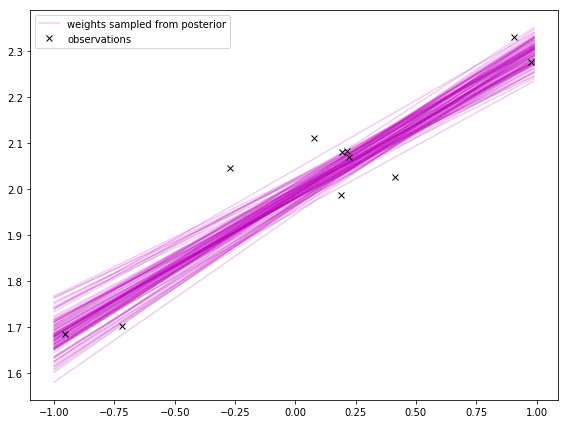

In [5]:
plt.clf()
plt.figure(figsize=(8, 6))
plt.plot(x_grid, Phi_X @ w.T, '-m', alpha=.2, label='weights sampled from posterior')
plt.plot(X_in, y, 'xk', label='observations')
plt.legend(*get_dedup_labels(plt))
maybe_save_plot('2018-01-10-samples')  # Graph showing x's for observations, a line from the mean Bayesian prediction, and shaded area of uncertainty.
plt.show()



## Prediction with uncertainty

I can also use `V_n` to compute the uncertainty of predictions. The prediction is the true function with some added noise:

$$y = f(\textbf x) + v$$

where \\(v \sim \mathcal N(0, \sigma_y^2)\\). With a little math, I can compute the mean and variance of the prediction posterior's Gaussian distribution. It's [also given in the course notes](http://www.inf.ed.ac.uk/teaching/courses/mlpr/2017/notes/w7a_bayesian_inference_prediction.html#predictions-for-bayesian-linear-regression).

Then I can take the square root of that to get the standard deviation and plot [2 standard deviations](https://en.wikipedia.org/wiki/68–95–99.7_rule) from the mean. In code:



In [6]:
grid_size = 0.01
x_grid = np.arange(-1, 1, grid_size)[:, None]

Phi_X = np.hstack((
    np.ones((x_grid.shape[0], 1)),  # pad with 1s for the bias term
    x_grid
))

stdev_pred = np.sqrt(np.sum(np.dot(Phi_X, V_n) * Phi_X, 1)[:, None] + sigma_y**2)

upper_bound = Phi_X @ w_n + 2 * stdev_pred
lower_bound = Phi_X @ w_n - 2 * stdev_pred

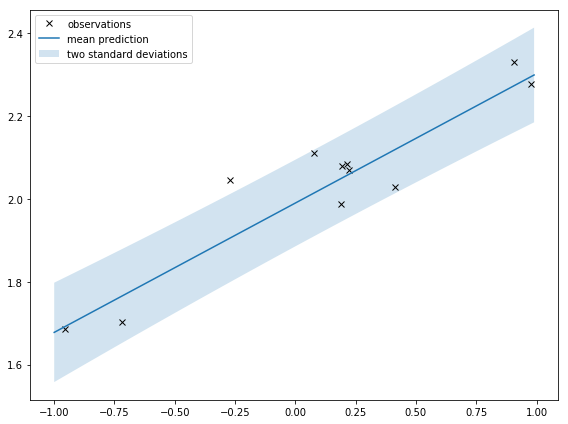

In [7]:
plt.clf()
plt.figure(figsize=(8, 6))
plt.plot(X_in, y, 'xk', label='observations')
# I think fill_between wants 1D arrays
plt.fill_between(x_grid[:, 0], lower_bound[:, 0], upper_bound[:, 0], alpha=0.2, label='two standard deviations')
plt.plot(x_grid, Phi_X @ w_n, label='mean prediction')
plt.legend()
maybe_save_plot('2018-01-10-uncertainty')  # Graph showing x's for observations, a line from the mean Bayesian prediction, and shaded area of uncertainty.
plt.show()

Neat!

If I zoom out like I do below, it's clearer that the shaded area is squeezed around the observations. That's saying there is less uncertainty around where the observations are. That's intuitive; I should be more certain of my prediction around observations.

![Graph showing x's for observations, a line from the mean Bayesian prediction, and shaded area of uncertainty.](images/2018-01-10-uncertainty-zoom-out.png)



### Comparison

The difference between these two plots confused me at first but sorting it out was instructive.

In the first plot, I'm sampling from the distribution of the *weights*. I hear sampling from the weights' distribution is not always easy to do. It turns out to be easy when doing Bayesian linear regression using Gaussians for everything.

The second plot shows the distribution of the *prediction*. This is related to the distribution of the weights (equation from [the course notes](http://www.inf.ed.ac.uk/teaching/courses/mlpr/2017/notes/w7a_bayesian_inference_prediction.html#predictions-for-bayesian-linear-regression)):

$$p(y|\mathbf x, \mathcal D) = \int p(y | \mathbf x, \mathbf w) p(\mathbf w|\mathcal D) \, d \mathbf w$$

If I look at a single weight sampled from the weight's posterior, I can plot
\\( p(y|\mathbf x, \mathbf w) \\)
which for each \\(\mathbf x\\) is \\(\mathcal N(y; \mathbf w^{\top} \mathbf x, \sigma_y^2)\\). If I plot it, I get:




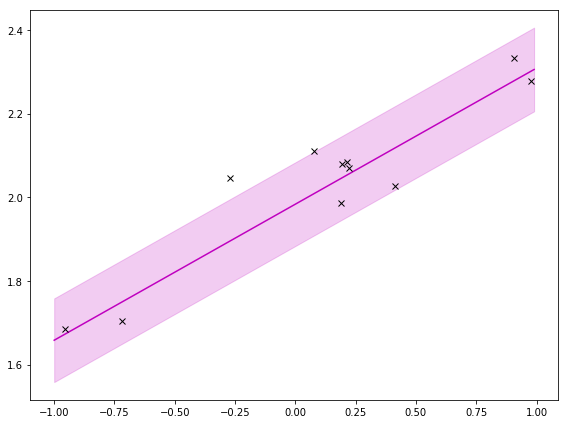

In [8]:
w = np.random.randn(1, 2) @ np.linalg.cholesky(V_n) + w_n.T

mean_pred = Phi_X @ w.T

plt.clf()
plt.figure(figsize=(8, 6))

upper_bound = mean_pred[:, 0] + 2 * sigma_y
lower_bound = mean_pred[:, 0] - 2 * sigma_y

plt.plot(x_grid, mean_pred[:, 0], '-m', label='weight sampled from posterior')
plt.fill_between(x_grid[:, 0], lower_bound, upper_bound, color='m', alpha=0.2, label='two standard deviations')

plt.plot(X_in, y, 'xk', label='observations')
maybe_save_plot('2018-01-10-sample-with-error')  # Graph showing x's for observations, a line for one sample of the weights, and shaded area for uncertainty.
plt.show()

To get the prediction, I use the integral, which does a weighted sum (or [expectation](https://en.wikipedia.org/wiki/Expected_value)!) over a bunch (all) of these. Then I get:

![Same as an image above: graph showing x's for observations, a line from the mean Bayesian prediction, and shaded area of uncertainty.](images/2018-01-10-uncertainty.png)


### Bonus: basis functions

With linear regression, I can also use basis functions to match even cooler functions.
For fun, I tried polynomials by using a different \\(\Phi \\). The true function was a quadratic. This shows
trying to fit a 5 degree polynomial to it:

    model_params = 6  # highest degree + 1
    Phi_X_in = np.hstack(X_in**i for i in range(model_params))


Sampling priors gave me lots of squiggles. (It also reminds me of my hair a few years ago!)

![Very squiggly lines.](images/2018-01-10-five-degrees.png)

I can plot the uncertainty.

![Uncertainty of 5-degree polynomial. It's very high far away from observations, and low close to observations.](images/2018-01-10-five-degrees-uncertainty-few.png)

I also can add a few more points from the underlying function and see how it changes.

![Uncertainty of 5-degree polynomial. It's very high far away from observations, and low close to observations. Now there's another observation far to the right, where the uncertainty pinches around it.](images/2018-01-10-five-degrees-uncertainty-another-point.png)


## See Also

 - Still thanks to [MLPR](http://www.inf.ed.ac.uk/teaching/courses/mlpr/2017/notes/)!
 - I originally posted the bonus [here](https://gist.github.com/jessstringham/827d8582eb4e3e0c26e9b16f6105621a).
